In [1]:
import numpy as np
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
def pinball_loss(f_N, theta, q):
    if np.isscalar(f_N):
        return q * (f_N - theta) if f_N >= theta else (1 - q) * (theta - f_N)
    diff_N = f_N - theta
    l_N = q * diff_N
    idx = np.where(diff_N < 0)[0]
    l_N[idx] = (1 - q) * -diff_N[idx]
    return l_N

def get_quantile(y_, q):
    assert(q >= 0 and q <= 1)
    sortedy_n = np.sort(y_)
    idx = int(np.ceil(q * y_.size)) - 1
    assert(idx <= y_.size - 1)
    if idx < 0:
        idx = 0
    return sortedy_n[idx]

def get_classical_ci(y_n, q, alpha):
    n = y_n.size
    l = sc.stats.binom.ppf(alpha / 2, n, q)
    ci_prob = sc.stats.binom.pmf(l, n, q)
    u = l
    while ci_prob < 1 - alpha:
        u += 1
        ci_prob += sc.stats.binom.pmf(u, n, q)
    # print(ci_prob, 1 - alpha, l, u)
    sortedy_n = np.sort(y_n)
    # TODO: u + 1 necessary? edge cases for l and u
    return sortedy_n[int(l)], sortedy_n[int(u + 1)]

def get_pai_ci_with_rectifier(y_n, y_N, f_n, f_N, q, quantile_lb, quantile_ub):
    n = y_n.size
    assert(f_n.size == n)
    N = f_N.size
    assert(delta < alpha)
    
    # compute imputed loss on imputed estimate
    theta_imputed = get_quantile(f_N, q)
    loss_N = pinball_loss(f_N, theta_imputed, q)
    loss_imputed = np.mean(loss_N)
    
    # compute "true" loss UB w/o approx as sanity check:
    rect = np.mean(np.abs(y_N - f_N)) * np.max([q, 1 - q])
    loss_ub = loss_imputed + 2 * rect
    
    # search for interval around imputed estimate
    fn = lambda theta: loss_ub - np.mean(pinball_loss(f_N, theta, q))
    assert(fn(theta_imputed) > 0)
    if fn(quantile_lb) > 0:
        lb = quantile_lb
    else:
        lb = sc.optimize.brentq(
            fn,
            quantile_lb,
            theta_imputed
        )
    if fn(quantile_ub) > 0:
        ub = quantile_ub
    else:
        ub = sc.optimize.brentq(
            fn,
            theta_imputed,
            quantile_ub
        )
    return (lb, ub), loss_imputed, rect, loss_ub

def get_pai_ci(y_n, y_N, f_n, f_N, q, alpha, delta, B, quantile_lb, quantile_ub):
    n = y_n.size
    assert(f_n.size == n)
    N = f_N.size
    assert(delta < alpha)
    
    # compute imputed loss on imputed estimate
    theta_imputed = get_quantile(f_N, q)
    loss_N = pinball_loss(f_N, theta_imputed, q)
    loss_imputed = np.mean(loss_N)
    
    # compute CLT CI on deviations between losses on Y and f
    absdiff_n = np.abs(y_n - f_n)
    mu = np.mean(absdiff_n)
    sigma = np.std(absdiff_n, ddof=1)
    z = sc.stats.norm.ppf(1 - delta, loc=0, scale=1)
    rect_ub = np.max([q, 1 - q]) * (mu + z * sigma / np.sqrt(n))
    
    
    # compute Hoeffding bound (root-N term)
    hoeffding_ub = np.sqrt(2) * B * np.sqrt(np.log(1 / (alpha - delta))) / np.sqrt(N)
    
    # compute UB on loss
    loss_ub = loss_imputed + 2 * rect_ub + hoeffding_ub
    
    # search for interval around imputed estimate
    fn = lambda theta: loss_ub - np.mean(pinball_loss(f_N, theta, q))
    if fn(quantile_lb) > 0:
        lb = quantile_lb
    else:
        lb = sc.optimize.brentq(
            fn,
            quantile_lb,
            theta_imputed
        )
    if fn(quantile_ub) > 0:
        ub = quantile_ub
    else:
        ub = sc.optimize.brentq(
            fn,
            theta_imputed,
            quantile_ub
        )
    return (lb, ub), loss_imputed, rect_ub, hoeffding_ub, loss_ub

def get_f(y_, off=0.1):
    raw = y_ + off * np.random.randn(y_.size)
    out = np.fmax(raw, -4)
    return np.fmin(out, 4)

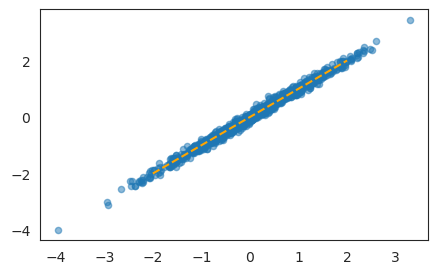

In [5]:
n = 1000
y_n = np.random.randn(n)
f_n = get_f(y_n, off=0.1)
plt.figure(figsize=(5, 3))
plt.scatter(y_n, f_n, s=20, alpha=0.5);
plt.plot([-2, 2], [-2, 2], linestyle='--', c='orange');
plt.show()

In [323]:
# single trial of full PPI CI on quantile
n = 100
N = 10000
off = 0.1
q = 0.5
alpha = 0.1
delta = 0.01
B = np.max([q, 1 - q]) * 8  # TODO: definitely the root-N term that is the problem
# think about B? other alternatives?
quantile_lb = -10
quantile_ub = 10

y_n = np.random.randn(n)
y_N = np.random.randn(N)
f_n = get_f(y_n, off=off)
f_N = get_f(y_N, off=off)

print(get_quantile(y_N, q))
ci_pai = get_pai_ci(
    y_n, y_N, f_n, f_N, q, alpha, delta, B, quantile_lb, quantile_ub)
print(ci_pai)


0.014474833740071835
((-0.7975572543602234, 0.7997433748701658), 0.43493353333779905, 0.06520418111416608, 0.0877805556355506, 0.5465412634553638)


In [358]:
# coverage of classical CI
ns = np.logspace(1, 3, 4)
N = 100000
q = 0.5
n_trial = 1000
alpha = 0.1

y_N = np.random.randn(N)
theta_star = get_quantile(y_N, q)
cov_nxt = np.zeros([ns.size, n_trial])
for n_idx, n in enumerate(ns):
    for t in range(n_trial):
        
        y_n = np.random.randn(int(n))
        
        ci_cla = get_classical_ci(y_n, q, alpha)
        cov_nxt[n_idx, t] = theta_star >= ci_cla[0] and theta_star <= ci_cla[1]
np.mean(cov_nxt, axis=1)

array([0.933, 0.921, 0.899, 0.888])

In [ ]:
# compare classical and idealized PPI with exact rectifier
ns = np.logspace(1, 3, 1)
N = 1000000
off = 0.1
q = 0.5
quantile_lb = -10
quantile_ub = 10
n_trial = 100
alpha=0.1

cilen_nxtx2 = np.zeros([ns.size, n_trial, 2])
lr_nxt = np.zeros([ns.size, n_trial, 2])
for n_idx, n in enumerate(ns):
    for t in range(n_trial):
        
        y_n = np.random.randn(int(n))
        y_N = np.random.randn(N)
        f_n = get_f(y_n, off=off)
        f_N = get_f(y_N, off=off)
        ci_pai, loss_imputed, rect, loss_ub = get_pai_ci_with_rectifier(
            y_n, y_N, f_n, f_N, q, quantile_lb, quantile_ub)
        ci_cla = get_classical_ci(y_n, q, alpha)
        cilen_nxtx2[n_idx, t] = ci_pai[1] - ci_pai[0], ci_cla[1] - ci_cla[0]
        lr_nxt[n_idx, t] = loss_imputed, rect
    print('done with {}'.format(n))

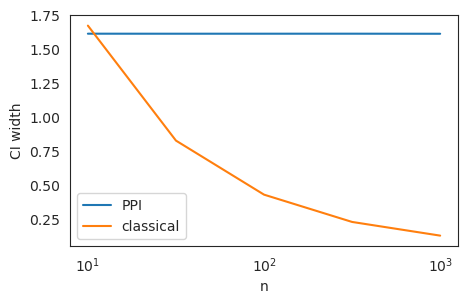

In [335]:
plt.figure(figsize=(5, 3))
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 0], axis=1), label='PPI')
plt.plot(ns, np.mean(cilen_nxtx2[:, :, 1], axis=1), label='classical')
plt.xscale('log')
plt.xlabel('n');
plt.ylabel('CI width');
plt.legend();
plt.show()

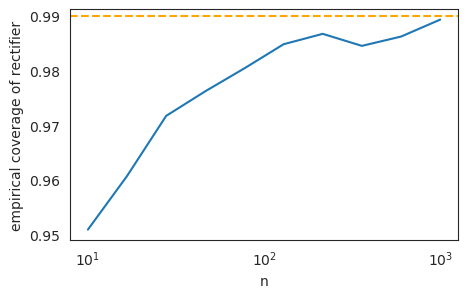

In [294]:
# sanity-check CLT UB on rectifier
ns = np.logspace(1, 3, 10)
N = 1000000
off = 0.5
q = 0.5
delta = 0.01
n_trial = 10000

y_N = np.random.randn(N)
f_N = get_f(y_N, off=off)
rect = np.mean(np.abs(y_N - f_N)) * np.max([q, 1 - q])

cov_nxt = np.zeros([ns.size, n_trial])
for n_idx, n in enumerate(ns):
    for t in range(n_trial):

        y_n = np.random.randn(int(n))
        f_n = get_f(y_n, off=off)

        absdiff_n = np.abs(y_n - f_n)
        mu = np.mean(absdiff_n)
        sigma = np.std(absdiff_n, ddof=1)
        z = sc.stats.norm.ppf(1 - delta, loc=0, scale=1)
        rect_ub = np.max([q, 1 - q]) * (mu + z * sigma / np.sqrt(n))

        cov_nxt[n_idx, t] = rect <= rect_ub
        
plt.figure(figsize=(5, 3))
plt.plot(ns, np.mean(cov_nxt, axis=1));
plt.xscale('log');
plt.xlabel('n');
plt.ylabel('empirical coverage of rectifier');
plt.axhline(1 - delta, linestyle='--', c='orange')
plt.show()

## show looseness from moving sup inside sum

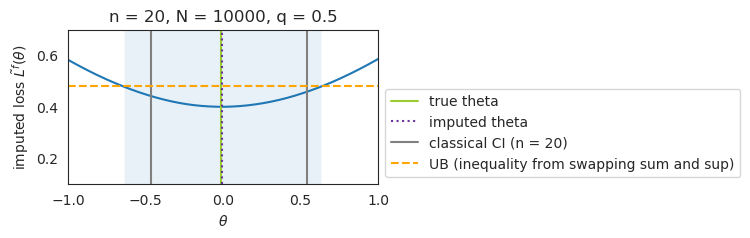

In [59]:
n = 20
N = 10000
q = 0.5
alpha = 0.1
label_noise_std = 0.1
thetas = np.arange(-4, 4, 0.01)

y_n = np.random.randn(n)
y_N = np.random.randn(N)
f_N = get_f(y_N, off=label_noise_std)

# \tilde{L}^f for different thetas
loss_theta = np.array([np.mean(pinball_loss(f_N, theta, q)) for theta in thetas])

# imputed quantities
theta_imputed = get_quantile(f_N, q)
loss_N = pinball_loss(f_N, theta_imputed, q)
loss_imputed = np.mean(loss_N)
ub = 2 * np.mean(np.abs(y_N - f_N)) * np.max([q, 1 - q])
idx = np.where(loss_theta <= loss_imputed + ub)[0]
ci_fromub = (thetas[np.min(idx)], thetas[np.max(idx)])

# true theta
theta_true = get_quantile(y_N, q)

# classical CI
ci_cla = get_classical_ci(y_n, q, alpha)

plt.figure(figsize=(4, 2));
plt.plot(thetas, loss_theta);
plt.axvline(theta_true, c='yellowgreen', label='true theta')
plt.axvline(theta_imputed, c='rebeccapurple', label='imputed theta', linestyle=':')
plt.axvline(ci_cla[0], c='gray', label='classical CI (n = {})'.format(n))
plt.axvline(ci_cla[1], c='gray')
plt.axhline(loss_imputed + ub, c='orange', linestyle='--',
            label='UB (inequality from swapping sum and sup)')
plt.fill_betweenx(np.array([0.0, 0.7]), ci_fromub[0], ci_fromub[1], alpha=0.1)
plt.legend(bbox_to_anchor=(1, 0, 1, 1));
plt.ylim([0.1, 0.7])
plt.xlim([-1, 1])
plt.xlabel(r'$\theta$');
plt.ylabel(r'imputed loss $\tilde{L}^f(\theta)$')
plt.title('n = {}, N = {}, q = {}'.format(n, N, q))
plt.show();